In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import math

In [2]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7512839771037106229
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4183621632
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17927730419543032619
physical_device_desc: "device: 0, name: GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [16]:
#tf.debugging.set_log_device_placement(True)

In [85]:
#making structured data for training
for index, row in df_train.iterrows():
    label = row['Sentiment']
    file = str(index) + '.txt'
    Path('corona_tweets/train/'+label).mkdir(parents=True, exist_ok=True)
    path = 'corona_tweets/train/' + label + '/' + file 
    f = open(path, "w")
    f.write(row['OriginalTweet'])
    f.close()

In [8]:
seed=101
train_ds = tf.keras.preprocessing.text_dataset_from_directory(
            directory='corona_tweets/train',
            labels='inferred',
            seed=seed,
            subset='training',
            validation_split=0.2)

Found 40994 files belonging to 5 classes.
Using 32796 files for training.


In [9]:
val_ds = tf.keras.preprocessing.text_dataset_from_directory(
            directory='corona_tweets/train',
            labels='inferred',
            seed=seed,
            subset='validation',
            validation_split=0.2)

Found 40994 files belonging to 5 classes.
Using 8198 files for validation.


In [171]:
class_names = train_ds.class_names

In [172]:
print(class_names)

['Extremely Negative', 'Extremely Positive', 'Negative', 'Neutral', 'Positive']


In [152]:
#for row in train_ds.take(3):
 #   print(row)
    
#printing data from tf dataset
for text_batch, label_batch in train_ds.take(1):
    for i in range(3):
        print("Review", text_batch.numpy()[i])
        print("Label", label_batch.numpy()[i])  

Executing op TakeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0
Review b'quarantine fears shoppers form long lines outside supermarket amid crisis uk'
Label 0
Review b'go get groceries take food drive thru say thank workers interact means lot bit kindness goes long way also dont panic buy'
Label 4
Review b'sideeffect coronavirus unfair racialization illness remember systems political economic healthcare contributed virus becoming pandemic concern people worldwide'
Label 0
Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0


In [2]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [3]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [4]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.2)(net)
    net = tf.keras.layers.Dense(5, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [5]:
classifier_model = build_classifier_model()

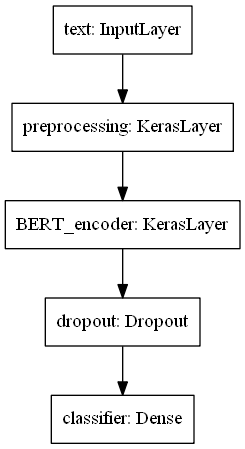

In [9]:
tf.keras.utils.plot_model(classifier_model)

In [6]:
epochs = 8
loss = tf.keras.losses.SparseCategoricalCrossentropy(name='sparse_categorical_crossentropy', from_logits=True)

classifier_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5), loss=loss, metrics=['accuracy'])

In [10]:
#es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=False)
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/8
1025/1025 [==============================] - 372s 358ms/step - loss: 1.0382 - accuracy: 0.5687 - val_loss: 0.7720 - val_accuracy: 0.6971
Epoch 2/8
1025/1025 [==============================] - 366s 357ms/step - loss: 0.7154 - accuracy: 0.7295 - val_loss: 0.6724 - val_accuracy: 0.7451
Epoch 3/8
1025/1025 [==============================] - 364s 356ms/step - loss: 0.5808 - accuracy: 0.7902 - val_loss: 0.6783 - val_accuracy: 0.7459
Epoch 4/8
1025/1025 [==============================] - 365s 356ms/step - loss: 0.4856 - accuracy: 0.8265 - val_loss: 0.7353 - val_accuracy: 0.7442
Epoch 5/8
1025/1025 [==============================] - 365s 356ms/step - loss: 0.3963 - accuracy: 0.8632 - val_loss: 0.7144 - val_accuracy: 0.7703
Epoch 6/8
1025/1025 [==============================] - 365s 356ms/step - loss: 0.3233 - accuracy: 0.8889 - val_loss: 0.7582 - val_accuracy: 0.7541
Epoch 7/8
1025/1025 [=====

In [35]:
#saving model
dataset_name = 'Corona_tweets'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

INFO:tensorflow:Assets written to: ./Corona_tweets_bert\assets


INFO:tensorflow:Assets written to: ./Corona_tweets_bert\assets


In [11]:
history.history

{'loss': [1.0382426977157593,
  0.7153850793838501,
  0.5808048844337463,
  0.48556914925575256,
  0.39625537395477295,
  0.32333847880363464,
  0.2677466869354248,
  0.21762973070144653],
 'accuracy': [0.5686973929405212,
  0.729509711265564,
  0.7901878356933594,
  0.8265032172203064,
  0.8631540536880493,
  0.8889498710632324,
  0.9068179130554199,
  0.9242590665817261],
 'val_loss': [0.7719665765762329,
  0.67243891954422,
  0.6783480048179626,
  0.7352585792541504,
  0.7143809795379639,
  0.7582122087478638,
  0.8376268148422241,
  0.9477615356445312],
 'val_accuracy': [0.697121262550354,
  0.7450597882270813,
  0.7459136247634888,
  0.744205892086029,
  0.7703098058700562,
  0.7540863752365112,
  0.7535984516143799,
  0.7553061842918396]}

In [12]:
import pickle
outfile = open('history_bert', 'wb')
pickle.dump(history.history, outfile)
outfile.close()

In [162]:
df_test = pd.read_csv('C:/Users/kusha/Documents/Corona_NLP_test.csv', encoding='latin1')
df_test = df_test.drop(['UserName','ScreenName','Location','TweetAt'], axis=1)
df_test.head()

,OriginalTweet,Sentiment
0,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,When I couldn't find hand sanitizer at Fred Me...,Positive
2,Find out how you can protect yourself and love...,Extremely Positive
3,#Panic buying hits #NewYork City as anxious sh...,Negative
4,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [163]:
for index, row in df_train.iterrows():
    label = row['Sentiment']
    file = str(index) + '.txt'
    Path('corona_tweets/test/'+label).mkdir(parents=True, exist_ok=True)
    path = 'corona_tweets/test/' + label + '/' + file 
    f = open(path, "w")
    f.write(row['OriginalTweet'])
    f.close()

In [13]:
test_ds = tf.keras.preprocessing.text_dataset_from_directory(
            directory='corona_tweets/test',
            labels='inferred')

Found 40994 files belonging to 5 classes.


In [14]:
classifier_model.evaluate(test_ds)

1282/1282 [==============================] - 230s 179ms/step - loss: 0.3051 - accuracy: 0.9101


[0.30514153838157654, 0.9100844264030457]

In [ ]:
#loss: 0.2805 - accuracy: 0.9174
#loss: 0.2684 - accuracy: 0.9234
#loss: 0.3051 - accuracy: 0.9101

In [16]:
#averaging test loss and accuracy 
ave_loss = (0.2805+0.2684+0.3051)/3
ave_accuracy = (0.9174+0.9234+0.9101)/3
print(ave_loss)
print(ave_accuracy)

0.2846666666666667
0.9169666666666667
